In [248]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

In [249]:
df = pd.read_csv('ml_data.csv')

In [250]:
df.head()

,type_of_property,price,building_condition,facade_number,living_area,equipped_kitchen,terrace,garden,subtype_ecoded,km_to_capital
0,0,149000.0,2,2.0,48,1,9,0,7,3.33
1,0,248000.0,2,2.0,91,1,2,0,7,3.91
2,0,229000.0,2,2.0,100,0,26,0,7,6.62
3,0,470000.0,2,2.0,179,2,10,0,7,5.29
4,0,480000.0,2,2.0,116,1,7,0,7,1.07


In [251]:
# Select the columns to be used   # 
features = ['type_of_property', 'building_condition', 'facade_number',
       'living_area', 'equipped_kitchen', 'terrace', 'garden',
       'subtype_ecoded', 'km_to_capital']

In [252]:
# Apply logarithm to the target col, so larger values are more compressed than small ones,
# making it easier for the model to handle outliers
df['price'] = np.log1p(df['price'])

In [253]:
# Split the data in features and target columns
X = df[features].values
y = df['price'].values.reshape(-1,1)

In [254]:
# Normalize the data
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X = scaler_x.fit_transform(X)
y = scaler_y.fit_transform(y) 

In [255]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [258]:
# Build model
model = Sequential()
model.add(Dense(128, input_shape=(9,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1)) # output layer

# Set an optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [273]:
#Train the model  
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=30, verbose=1, mode='auto', restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test[:1000], y_test[:1000]), callbacks=[monitor], shuffle=False, epochs=10, batch_size=32)

Epoch 1/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3128 - mae: 0.4101 - val_loss: 0.3327 - val_mae: 0.4180
Epoch 2/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3142 - mae: 0.4077 - val_loss: 0.3230 - val_mae: 0.4110
Epoch 3/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3466 - mae: 0.4263 - val_loss: 0.3173 - val_mae: 0.4106
Epoch 4/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3179 - mae: 0.4106 - val_loss: 0.3340 - val_mae: 0.4171
Epoch 5/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3148 - mae: 0.4073 - val_loss: 0.3240 - val_mae: 0.4137
Epoch 6/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3162 - mae: 0.4096 - val_loss: 0.3254 - val_mae: 0.4138
Epoch 7/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3196 - mae: 0.4120 - val_loss: 0.3329 - val_mae: 0.4129
Epoch 8/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3169 - mae: 0.4099 - val_loss: 0.3237 - val_mae: 0.4128
Epoch 9/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


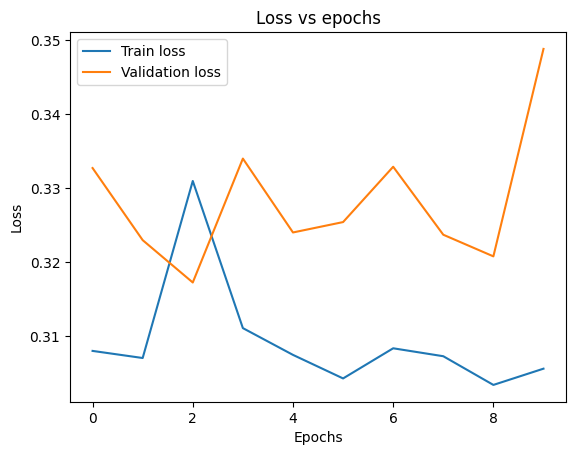

In [274]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [275]:
# Make predictions
X_test1 = X_test[:100]
y_test1 = y_test[:100]

predictions = model.predict(X_test1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [276]:
# Convert predictions back to euros

# reverse the scaled data:
predictions_log = scaler_y.inverse_transform(predictions)

# reverse the logarith applied to target (price)
predictions_actual = np.expm1(predictions_log)

In [277]:
# Same process for the actual values of the price col
y_test1_log = scaler_y.inverse_transform(y_test1)
y_test_normal = np.expm1(y_test1_log)

In [278]:
# Make df for better interpretation
predictions_actual = pd.DataFrame(predictions_actual)
price_actual = pd.DataFrame(y_test_normal)

compare_df = pd.concat([predictions_actual, price_actual], axis = 1)
column_names = ['predictions', 'actual_price']
compare_df.columns = column_names

#compare_df['difference'] = compare_df.apply('predictions' - 'actual_price')

compare_df

,predictions,actual_price
0,351708.968750,495000.0
1,401726.843750,349000.0
2,246451.515625,197000.0
3,307200.937500,249000.0
4,305164.531250,255000.0
...,...,...
95,452094.343750,950000.0
96,260318.890625,139000.0
97,587973.062500,579000.0
98,396394.687500,365000.0


In [ ]:
rmes_history = []

In [ ]:
#mse = mean_squared_error(y_test_normal, predictions_actual)
rmse = root_mean_squared_error(y_test_normal, predictions_actual)
print("Root Mean Squared Error:", rmse)
rmes_history.append(round(rmse))

Root Mean Squared Error: 299880.02303872735


In [280]:
rmes_history

[np.float64(330971.79491770896), np.float64(299880.02303872735)]